# Notebook for multi-state prediction

In [1]:
import sys
from pathlib import Path

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import modules from the parent directory
import torch
from helpers.simulation import *
from helpers.models import *
from helpers.eval import *
from settings import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

## Multi-state: Isotropic

In [2]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss_coeff,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
                    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/multi_state_iso_250000_15_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

Using device: cuda
Total params of MultiStateModel: 925026


MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [3]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = ISOTROPIC_PROPS

#np.random.seed(1)

losses = []
for i in range(1):
    all_videos, og_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=False)

    loss = multi_state_eval_isotropic(all_videos, og_displacements, og_labels, disp_stats, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Average loss across validation set: 0.008700273153935649
Average MAE of diffusion coefficients and angle simularity across validation set: [0.3968728  0.39670166]
--------------------------------------------------
Average loss: 0.008700273153935649
Std of loss: 0.0


## Multi-state: Binding

In [4]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
                    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results/multi_state_binding_250000_20_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

Using device: cuda
Total params of MultiStateModel: 925284


MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [5]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = BINDING_IMAGE_PROPS

losses = []
for i in range(1):
    all_videos, og_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

    loss = multi_state_eval(all_videos, og_displacements, og_labels, disp_stats, model, model_props['loss_fn'], image_props['D_max_norm'], device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Creating a binding dataset
Average loss across validation set: 0.3528583366305206
Average MAE of diffusion coefficients and angle simularity across validation set: [0.2871877  0.22870094 0.94348717]
--------------------------------------------------
Average loss: 0.3528583366305206
Std of loss: 0.0


## Changepoint Detection

In [ ]:
all_videos = torch.Tensor(all_videos)
all_displacements = normalize_displacements(og_displacements, disp_stats)
all_displacements = torch.Tensor(all_displacements)

D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])
all_labels = torch.Tensor(all_labels)

# Create dataset and dataloader
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

plot_preds = []
plot_labels = []

with torch.no_grad():    
    for videos, displacements, labels in dataloader:
        videos = videos.to(device)
        labels = labels.to(device)
        
        if displacements.numel() != 0:
            displacements = displacements.to(device)
            val_predictions = model(videos, displacements)
        else:
            val_predictions = model(videos)
        
        plot_preds.extend([p.cpu() for p in val_predictions])
        plot_labels.extend([l.cpu() for l in labels])

In [7]:
changepoints_pred = get_changepoints(np.array(plot_preds)[...,:2])
changepoints_label = get_changepoints(np.array(plot_labels)[...,:2])

@interact(i=IntSlider(value=0, min=0, max=len(plot_preds), step=1))
def plot_point_based(i):
    # Plot predictions and labels across frames
    fig, (ax1,ax2) = plt.subplots(2,1)

    pred_D1 = plot_preds[i][:,0] * D_max_normalization
    pred_D2 = plot_preds[i][:,1] * D_max_normalization
    label_D1 = plot_labels[i][:,0] * D_max_normalization
    label_D2 = plot_labels[i][:,1] * D_max_normalization

    ax1.plot(pred_D1, label='Prediction')
    ax1.plot(label_D1, label='Label')
    ax2.plot(pred_D2)
    ax2.plot(label_D2)
    
    fig.suptitle('Point-based Prediction')
    ax1.set_ylabel(r'$D_{1}$ ($\frac{\mu m^2}{s}$)')
    ax2.set_ylabel(r'$D_{2}$ ($\frac{\mu m^2}{s}$)')
    fig.supxlabel('Frame')
    fig.legend()
    plt.show()
    
    print(f"Predicted changepoint: {changepoints_pred[i]}")
    print(f"True changepoint: {changepoints_label[i]}")

interactive(children=(IntSlider(value=0, description='i', max=5000), Output()), _dom_classes=('widget-interact…

In [8]:
# Average number of frames away from true transition point
np.abs(changepoints_pred - changepoints_label).mean()

np.float64(0.4184)

In [9]:
errors = np.abs(changepoints_pred - changepoints_label)

vals, cnts = np.unique(errors, return_counts=True)

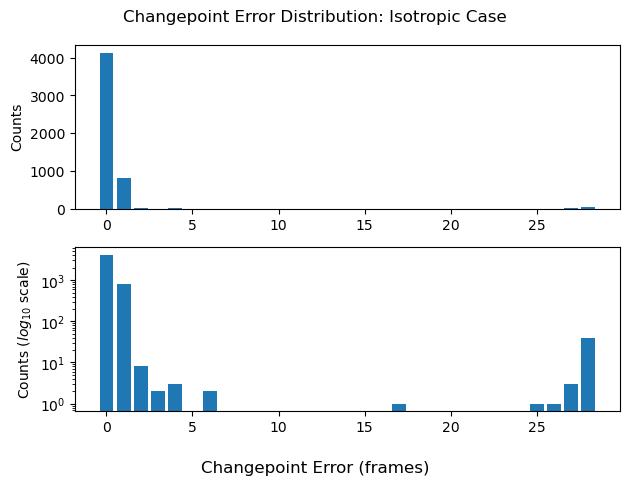

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.bar(vals, cnts)
ax1.set_ylabel('Counts')

ax2.bar(vals, cnts)
ax2.set_yscale('log')
ax2.set_ylabel(r'Counts ($log_{10}$ scale)')

fig.supxlabel('Changepoint Error (frames)')
fig.suptitle('Changepoint Error Distribution: Isotropic Case')
fig.tight_layout()
plt.show()